# 1次元問題の差分法シミュレーション：実践編

In [2]:
import numpy as np
import sys
if 'google.colab' in sys.modules:
    print("Installing pygmt on Google Colab. It may take a few minutes.")
    ! pip install -q condacolab &> /dev/null
    import condacolab
    condacolab.install()
    ! mamba install pygmt &> /dev/null
import pygmt

これまでに導いた1次元差分法のアルゴリズム

$$
\begin{align}
	 &	\sigma_i \leftarrow \sigma_i
	 + 
	 G_i \frac{v_i - v_{i-1} }{\Delta x} \Delta t 
	\\
	 & v_i  \leftarrow  v_i
	 + 
	 \frac{1}{\rho_i } 
	 \frac{\sigma_{i+1} - \sigma_{i-1} }{\Delta x} \Delta t
\end{align}
$$
を使って，実際に波動の伝播をシミュレーションしてみましょう．

これから作るプログラムは，

- パラメタの設定と変数（メモリ）の確保
- 初期条件の設定
- 差分法による時間発展の計算とデータ出力

という部分からなります．導出したアルゴリズムはこのうちの一番最後の部分ですが，その計算のまえにいくらかの準備が必要です．

この数値シミュレーションでは，空間 $x$ と時間 $t$ を離散化していますから，それぞれの離散化幅 $\Delta x$, $\Delta t$ を定める必要があります．また，無限に広い領域の計算をするわけにはいきませんから，空間と時間それぞれについてのグリッドの個数も定めます．

これらのパラメタをどうやって適切に定めるのか，は重要な話題なのですが，ここではまず実践ということで，適当に値を設定してみます．

In [3]:
dx = 0.2               # 空間グリッドサイズ (km)
dt = 0.05              # 時間ステップサイズ (s)
nx = 1001              # 空間グリッド数
nt = 401               # 時間ステップ数

V   = np.zeros(nx+1)   # 変位速度 V[0] ... V[nx] をゼロで確保．以下同様
S   = np.zeros(nx+2)   # 応力
rho = np.zeros(nx+1)   # 質量密度
G   = np.zeros(nx+1)   # 弾性係数

ここでは，`np.zeros` 関数を用いてメモリを確保しました．この関数は引数に与えられた個数リストを確保し，その値をすべて `0` で初期化します．プログラミング言語ではギリシャ文字は使いにくい（Pythonでは使えないこともないが，入力が不便）のため，$\sigma$ は `S`, $\rho$ は `rho` としました．

続けて，媒質と初期条件の設定です．数値シミュレーションの中では，質量密度と剛性率が必要です．一方，地震学的には剛性率そのものよりも地震波速度のほうがわかりやすいので，ここでは
$\beta = \sqrt{G/\rho}$ として，地震波速度 $\beta$ を通じて媒質を特徴づけることにします．

In [4]:
# 媒質の設定
for i in range(nx+1):
    beta   = 4.0                   # 仮定する地震波速度 (km/s)
    rho[i] = 2.7                   # 仮定する質量密度 (g/cm^3)
    G[i]   = rho[i] * beta * beta  # 剛性率に換算

x = np.linspace(0, dx*(nx-1), nx+1)

ここでは，地震波速度を 4 km/s の一定値，質量密度を 2.7 g/cm$^3$ の一定値としました．また，あとで用いるため，$x$軸にそった各セルの位置の座標値を，`x` というリストに設定しました．`np.linspace()` は指定範囲内で等間隔の数列を生成する関数です．

さらにつづけて初期条件を設定します．本当の断層運動による地震波の生成は，複数の等価体積力の組み合わせで得られるのですが，ここでは簡単のため，粒子速度$v$があらかじめ有限の値を持っていた，という状態を初期値として設定してみます．

In [5]:
L  = 8.0               # 初期条件の波長 (km)

# 初期条件
hw = int(L/2/dx + 0.5) # 半値幅
for i in range(-hw, hw+1):
    V[int((nx - 1)/2)+1+i] = np.cos(np.pi/2.0*i/hw)**2

n = 0 # 時間ステップの値（ファイル名に利用）

# 結果出力ファイル
with open(f'out_{n*dt:08.4f}_.dat', 'w') as fp:
    for i in range(nx+1):
        print(f"{(i-1)*dx:12.4e} {V[i]:12.4e}", file=fp)    

上記のコードは，変数 `L` で指定した長さの幅をもつ，$\cos$関数で表されるような滑らかなベル型の初期条件を $x$ 軸中央に設定しています．このコードを実行すると，$x$と$v$の値がファイル `out_000.0000_.dat` に出力されますから，それを読み込んでプロットしてみましょう．

In [8]:
d = np.loadtxt(f'out_000.0000_.dat').T
print(d)

[[ -0.2   0.    0.2 ... 199.6 199.8 200. ]
 [  0.    0.    0.  ...   0.    0.    0. ]]


`np.loadtxt`は読み込んだファイルを1行ずつのリストにしますが，いま欲しいのは1列ずつのリストです．そこで，`loadtxt`のあとに `.T` （行列の転置）をつけることによって列ごとのデータに変換しています．ここまでくれば，プロットは簡単です．

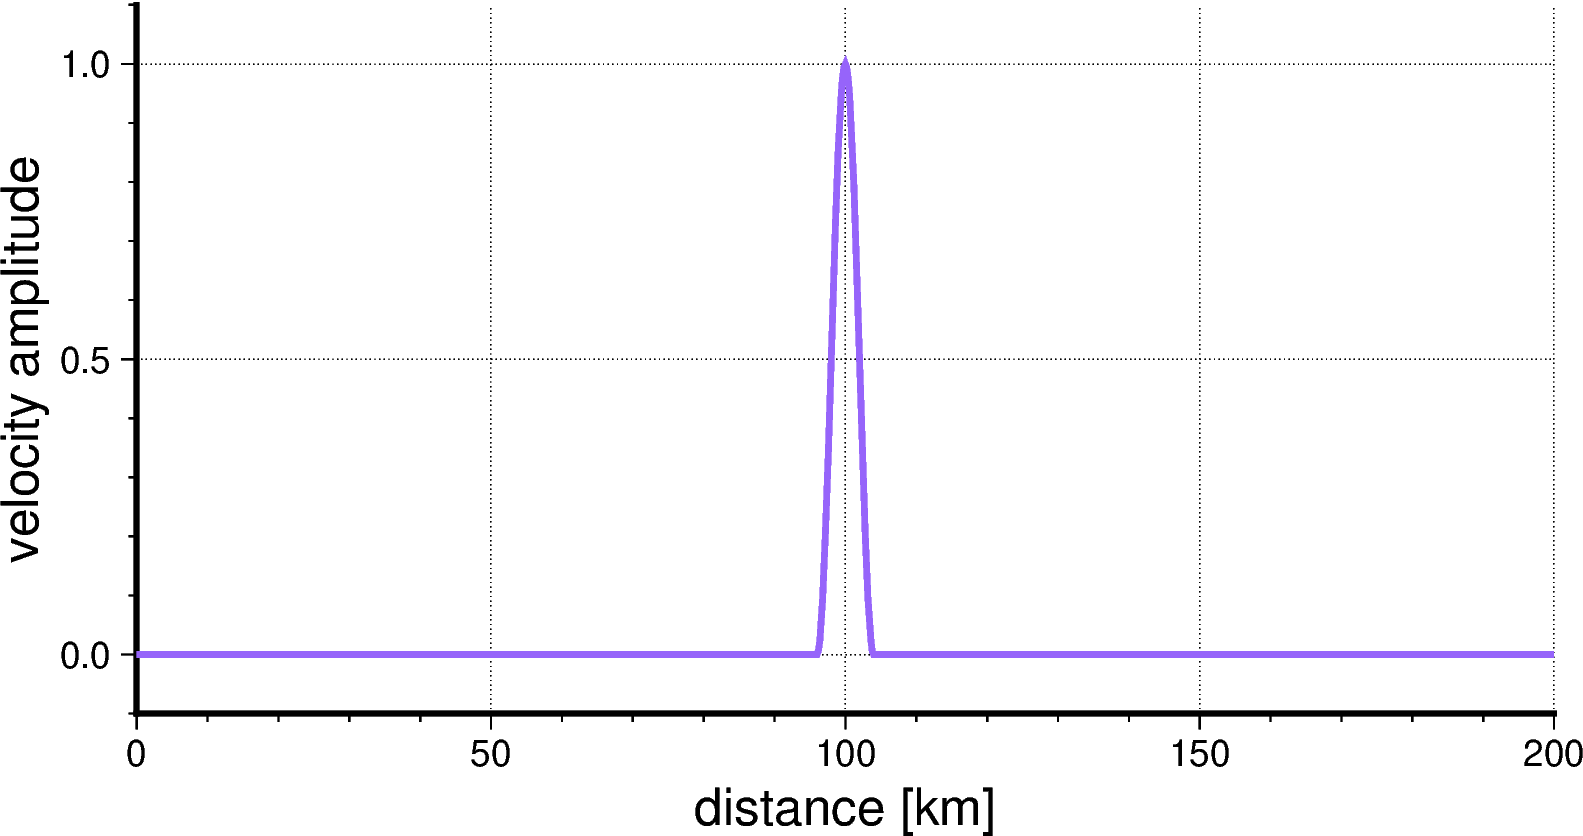

In [10]:
fig = pygmt.Figure()
with pygmt.config(MAP_GRID_PEN_PRIMARY = '0.25p,30/30/30,.'): 
    fig.basemap(projection='X12c/6c', region=[0, 200, -0.1, 1.1], 
            frame = ['WS', 'xafg+ldistance [km]', 
                           'yafg+lvelocity amplitude'])
    fig.plot(x=d[0], y=d[1], pen='thicker,150/100/250')
fig.show()

たしかに，中央付近に初期条件が設定されていることがわかります．

それでは，いよいよスタガードグリッド差分法の中核部分です．

In [12]:
# 時間発展
for n in range(1, nt+1):

    # 構成関係式
    for i in range(1, nx+1):
        dxV = ( V[i] - V[i-1] ) / dx # 変位速度の空間微分
        S[i] += G[i] * dxV * dt      # 応力の更新

    # 運動方程式
    for i in range(1, nx+1):
        dxS = ( S[i+1] - S[i] ) / dx # 応力の空間微分
        V[i] += dxS / rho[i] * dt    # 変位速度の更新

    # ( n % m == 0 ) は m 回に1回 True になることを利用して出力を間引き
    if n % 5 == 0:
        with open(f'out_{n*dt:08.4f}_.dat', 'w') as fp:
            for i in range(nx+1):
                print(f"{(i-1)*dx:12.4e} {V[i]:12.4e}", file=fp)

一番外側に時間についてのループがあり，`n=0, 1, ..., nt` まで繰り返します．内側には空間についてのループが2つあり，それぞれ構成関係式・運動方程式に対応しています．それぞれのループ内で行っている計算は，本ノートブックの先頭にかかれているアルゴリズムとまったく同じです．

一方，コードの後半では計算結果の出力をしています．毎時間ステップのデータを出力するとやや分量が多いため，`n % 5 == 0` という条件を課して，5ステップごとにデータを出力するようにしています．出力ファイルは，`out_時間_.dat` という名前で保存されます．このひとつひとつのデータは，初期条件をプロットしたスクリプトと同様に可視化することができます．

### 実践 1次元地震波数値シミュレーション

では，いきなりですが，ここまでで得られたアルゴリズムを踏まえて数値シミュレーションを実施してみましょう．

In [ ]:
dx = 0.2               # 空間グリッドサイズ (km)
dt = 0.05              # 時間ステップサイズ (s)
nx = 1001              # 空間グリッド数
nt = 401               # 時間ステップ数
L  = 8.0               # 初期条件の波長 (km)

V   = np.zeros(nx+1)   # 変位速度
S   = np.zeros(nx+2)   # 応力
rho = np.zeros(nx+1)   # 質量密度
G   = np.zeros(nx+1)   # 弾性係数

# 媒質の設定
beta   = 4.0               # 仮定する地震波速度 (km/s)
rho[:] = 2.7               # 仮定する質量密度 (g/cm^3)
G[:]   = rho * beta * beta # 剛性率 G = ρ x β^2

# 初期条件
hw = int(L/2/dx + 0.5)
for i in range(-hw, hw+1):
    V[int((nx - 1)/2)+1+i] = np.cos(np.pi/2.0*i/hw)**2

# 結果出力ファイルの準備と初期状態の出力
n = 0
fp = open('out.dat', 'w')
for i in range(1, nx+1):
    print(f"{(i-1)*dx:12.4e} {n*dt:12.4e} {V[i]:12.4e} {S[i]:12.4e}", 
          file=fp)

# 時間発展
for n in range(1, nt+1):
   
    # 構成関係式
    for i in range(1, nx+1):
        dxV = ( V[i] - V[i-1] ) / dx
        S[i] += G[i] * dxV * dt

    # 運動方程式
    for i in range(1, nx+1):
        dxS = ( S[i+1] - S[i] ) / dx
        V[i] += dxS / rho[i] * dt

    # データ出力
    for i in range(1, nx+1):
        print(f"{(i-1)*dx:12.4e} {n*dt:12.4e} {V[i]:12.4e} {S[i]:12.4e}", 
              file=fp)
    
fp.close()

コメントに「時間発展」とか書かれているところから先が差分法による数値シミュレーションのメイン部分です．数式通りに，まず右辺の空間微分を差分近似で評価し，時間差分を整理した結果をつかって左辺の値をアップーデートする，という流れで計算が進んでいることがわかるでしょうか．

上記コードを実行すると，`out.dat` というファイルが作られます．その中身の一部を取り出してみると，

```
  4.8200e+01   1.2800e+01   4.8168e-01   5.0092e+00
  4.8400e+01   1.2800e+01   4.9384e-01   5.2022e+00
  4.8600e+01   1.2800e+01   5.0000e-01   5.3335e+00
  4.8800e+01   1.2800e+01   5.0000e-01   5.4000e+00
  4.9000e+01   1.2800e+01   4.9384e-01   5.4000e+00
  4.9200e+01   1.2800e+01   4.8168e-01   5.3335e+00
```

のように4列からなるデータです．このデータは，左2列から位置 `x`, 時刻 `t`で，その位置と時間における変位速度 `V`, 応力 `S` の変数が3列目と4列目に格納されています．つまりこのデータ一つで，地震波の時間・空間両方の広がりが記述されていることになります．

いま興味があるのは位置・時間と変位速度ですので，結果ファイルからこれらを取り出します．

In [ ]:
d = np.loadtxt('out.dat') # 1行ずつのリストの集合体として読み込まれる
xx, tt, VV, _  = d.T      # 転置 `.T` により1列ごとのデータに変換する

このデータを可視化してみます．各地点における地震波形のレコードセクションを作成してみましょう．

In [ ]:
def wvplot_record(xx, tt, VV): 
    """シミュレーション結果のレコードセクション表示"""

    scale = 25
    
    fig = pygmt.Figure()

    fig.basemap(projection='X12c/8c', region=[0, 20, 0, 200], 
                frame = ['WS', 'xaf+ltime [s]', 'yaf+ldistance [km]'])
    
    for x in np.arange(0, 200, 2):

        # 位置 xx がループ変数 x に十分に近いところの時間・変位速度を取り出す
        mask = np.where(np.isclose(xx, x))
        ttt = tt[mask]
        VVV = VV[mask]

        # y軸位置を距離分だけずらしてプロットする
        fig.plot(x=ttt, y=x+VVV*scale, pen='thinner,black@50')

    return fig

In [ ]:
wvplot_record(xx, tt, VV)

続けて，振幅分布のアニメーションです．以下の関数 `wvplot_anim` は，時刻 0 から 20秒まで，0.2秒ずつの振幅分布をすべて作成します．それをパラパラマンガとして動画化してくれるのが，その次の `gif_movie` 関数です．

In [ ]:
def wvplot_anim(xx, tt, VV): 

    figs = []

    for t in np.arange(0, 20, 0.2):

        fig = pygmt.Figure()
        with pygmt.config(MAP_GRID_PEN_PRIMARY = '0.25p,30/30/30,.'): 
            fig.basemap(projection='X12c/6c', region=[0, 200, -0.1, 1.1], 
                        frame = ['WS', 
                                 'xafg+ldistance [km]', 
                                 'yafg+lvelocity amplitude'])
        mask = np.where(np.isclose(tt, t))
        xxx = xx[mask]
        VVV = VV[mask]
    
        fig.plot(x=xxx, y=VVV, pen='thicker,150/100/250')
        fig.text(x=198, y = 0.98, justify='RT', text=f"t = {t:5.1f} s", 
                 font='12p,Helvetica,Black')
        figs.append(fig)

    return figs

In [ ]:
def gif_movie(figs, dpi=720, crop='0.5c'): 
    
    """
    PyGMTのFigureオブジェクトのリストからGifアニメーションを作成する．Jupyter Notebook上で表示されるオブジェクトを返す．

    Parameters
    ----------
    figs : list of Figure
        PyGMTのFigureオブジェクトのリスト
    dpi : int, optional
        解像度 (default: 720)
    crop : str, optional
        余白のトリミング量 (default: '0.5c')

    Returns
    -------
    HTML : IPython.display.HTML
        Gifアニメーション
    """
    from IPython import display as dd
    import tempfile
    import base64
    import os
    
    with tempfile.TemporaryDirectory() as tmpdir:
        for i, fig in enumerate(figs):
            figname = f'plot_{i:05d}.png'
            print(f'\rsaving figs ... ({(i+1)/len(figs)*100:5.1f}%)', end='')
            fig.savefig(os.path.join(tmpdir, figname), dpi=dpi, crop=crop)
        print(' Done.')
        
        cmd1 = f'ffmpeg -i {tmpdir}/plot_%5d.png '
        cmd2 = f' -vf "scale=800:-1,split [a][b];[a] palettegen [p];[b][p] paletteuse" '
        cmd3 = f' {tmpdir}/out.gif > /dev/null 2>&1'
        print(f'making gif ... ', end='')
        os.system(cmd1 + cmd2 + cmd3)
        print(' Done.')
        
        with open(f'{tmpdir}/out.gif', 'rb') as f:
            b64 = base64.b64encode(f.read()).decode("ascii")
        
    return dd.HTML(f'<img src="data:image/gif;base64,{b64}" width="80%"/>')

In [ ]:
ff = wvplot_anim(xx, tt, VV)

In [ ]:
gif_movie(ff) #1分くらいかかります．辛抱強く待ちましょう．

これで一通りの1次元地震波伝播シミュレーションが出来上がりました．このシミュレーションは，`beta` や `rho` のパラメタを変えるだけで，不均質な媒質中の地震波伝播を再現できます．実際にパラメタを変えて，色々試してみましょう．